# An example workflow for generating hypotheses with ABCD data

## Installing dependent Python packages
One way to do this is with a virtual python environment installed so that it is accessible to Jupyter lab.  This needs to be set up only once.
```bash
python -m venv ~/abcd311
source ~/abcd311/bin/activate
pip install ipykernel
python -m ipykernel install --user --name abcd311
pip install -r requirements.txt
```
Then, once Jupyter is open with this lab notebook, "Change Kernel..." to be "abcd311".

## Import dependent Pyton packages

In [1]:
# Import from Python packages
from typing import Any, Union
import csv
import dipy.io.image
import functools
import math
import matplotlib.pyplot as plt
import nibabel as nib
import nibabel.nifti1
import nilearn.maskers
import nilearn.masking
import nilearn.mass_univariate
import numpy as np
import os
import pandas as pd
import random
import re
import statsmodels.api as sm
import time

## Set global variables

In [2]:
# Set global parameters to match your environment.  Ultimately these will be member variables of a class
gor_image_directory: str = "/data2/ABCD/gor-images"
white_matter_mask_file: str = os.path.join(gor_image_directory, "gortemplate0.nii.gz")
coregistered_images_directory: str = os.path.join(gor_image_directory, "coregistered-images")
tabular_data_directory: str = "/data2/ABCD/abcd-5.0-tabular-data-extracted"
core_directory: str = os.path.join(tabular_data_directory, "core")

# Useful class static const member
# Images are distinguished from each other by their subjects and timing.  (Also distinguished as "md" vs. "fa" type, though not relevant here.)
join_keys: list[str] = ["src_subject_id", "eventname"]

## Define functions for various steps of the workflow

In [3]:
# Functions for handling image voxel data


def get_list_of_image_files(directory: str) -> list[str]:
    """
    Returns a list of full path names of image files.  Input is the directory in which to look for these files.
    """
    # Choose the pattern to get .nii.gz files but avoid the template files such as gortemplate0.nii.gz
    pattern: str = r"^gorinput[0-9]{4}-.*\.nii\.gz$"
    response: list[str] = [
        os.path.join(directory, file)
        for file in os.listdir(directory)
        if bool(re.match(pattern, file))
    ]
    return response


def parse_image_filenames(list_of_image_files: list[str]) -> pd.core.frame.DataFrame:
    """
    Given a list of image file names, returns a pandas DataFrame.
    The first column in the output is the filename.
    Additional columns indicate how the filename was parsed.
    For example, run as:
        df = parse_image_filenames(get_list_of_image_files(coregistered_images_directory))
    """
    filename_pattern: str = (
        r"gorinput([0-9]+)-modality([0-9]+)-sub-([A-Za-z0-9]+)_ses-([A-Za-z0-9]+)_run-([A-Za-z0-9]+)_([A-Za-z0-9]+)_([A-Za-z0-9]+)-([A-Za-z0-9]+).nii.gz"
    )
    filename_keys: list[str] = [
        "filename",
        "gorinput",
        "modality",
        "src_subject_id",
        "eventname",
        "run",
        "image_type",
        "image_subtype",
        "processing",
    ]

    # Parse the basename of each filename and use it to construct a row of the `response` dataframe
    response: pd.core.frame.DataFrame = pd.DataFrame(
        [
            [filename, *list(re.match(filename_pattern, os.path.basename(filename)).groups())]
            for filename in list_of_image_files
        ],
        columns=filename_keys,
    )

    # Fix parsing of src_subject_id.  The filenames do not have an underscore after "NDAR",
    # but src_subject_id values in the data tables do.
    response["src_subject_id"] = [
        re.sub(r"^NDAR", "NDAR_", subject) for subject in response["src_subject_id"]
    ]
    # Fix parsing of eventname.  The filenames use CamelCase but the datatables use snake_case.
    eventname_conversion: dict[str, str] = {
        "baselineYear1Arm1": "baseline_year_1_arm_1",
        "1YearFollowUpYArm1": "1_year_follow_up_y_arm_1",
        "2YearFollowUpYArm1": "2_year_follow_up_y_arm_1",
        "3YearFollowUpYArm1": "3_year_follow_up_y_arm_1",
        "4YearFollowUpYArm1": "4_year_follow_up_y_arm_1",
    }
    response["eventname"] = [eventname_conversion[event] for event in response["eventname"]]

    return response


def get_data_from_image_files(list_of_files: list[str]) -> list[Any]:
    """
    get_data_from_image_files returns a list of tuples of 4 values.
    The latter 3 values in the tuple are the return from load_nifti.
        <class 'str'>: full file name
        <class 'numpy.ndarray'>: image data as a numpy array
        <class 'numpy.ndarray'>: some other numpy array (transform?)
        <class 'nibabel.nifti1.Nifti1Image'>: an object that can be modified and can be written to file as a .nii.gz file
    """
    response = [(file,) + dipy.io.image.load_nifti(file, return_img=True) for file in list_of_files]
    return response


def get_white_matter_mask_as_numpy(
    white_matter_mask_file: str, mask_threshold: float
) -> np.ndarray:
    # The return value is a np.ndarray of bool, a voxel mask that indicates which voxels are to be kept for subsequent analyses.
    # The mask is flattened to a single dimension because our analysis software indexes voxels this way
    # We determine white matter by looking at the white_matter_mask_file for voxels that have an intensity above a threshold
    white_matter_mask_input: np.ndarray = get_data_from_image_files([white_matter_mask_file])[0][1]
    white_matter_mask: np.ndarray = (white_matter_mask_input >= mask_threshold).reshape(-1)
    print(f"Number of white matter voxels = {np.sum(white_matter_mask)}")
    return white_matter_mask

In [4]:
# Functions for reading and selecting data from csv files


def csv_file_to_dataframe(filename: str) -> pd.core.frame.DataFrame:
    """
    A stupid function that reminds us how to read a csv file using pandas
    """
    return pd.read_csv(filename)


def select_rows_of_dataframe(df: pd.core.frame.DataFrame, query_dict: dict[str, str]):
    """
    This function is deprecated in favor of using pandas `isin` functionality.
    """
    # Each key of query_dict is a column header of the df dataframe.
    # Each value of query_dict is a list of allowed values.
    # A row will be selected only if each of these columns has one of the allowed keys
    assert all(key in df.columns for key in query_dict.keys())
    # Old code: each of query_dict.values() is just a single value, not a list of values:
    # rows = df[
    #     functools.reduce(lambda x, y: x & y, [df[key] = value for key, value in query_dict.items()])
    # ]
    rows: pd.core.frame.DataFrame = df[
        functools.reduce(
            lambda x, y: x & y,
            [
                functools.reduce(lambda x, y: x | y, [df[key] == value for value in values])
                for key, values in query_dict.items()
            ],
        )
    ]
    return rows

In [5]:
# Functions to read and cache KSADS tabular information


def clean_ksads_data_frame(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """
    KSADS data uses:
        1 = present
        0 = absent
        888 = Question not asked due to primary question response (branching logic)
        555 = Not administered in the assessment
    At least for now, we will assume:
        that 888 means that the question was not asked because the answer was already known to be "absent".
        that 555 means we don't know the answer.
    See https://wiki.abcdstudy.org/release-notes/non-imaging/mental-health.html
    """
    for column in df.columns:
        if bool(re.match("ksads_\d", column)):
            df[column] = df[column].astype(float)
            df.loc[df[column] == 555, column] = np.nan
            df.loc[df[column] == 888, column] = 0
    return df


def ksads_filename_to_dataframe(
    file_mh_y_ksads_ss: str, use_cache: bool = True
) -> pd.core.frame.DataFrame:
    """
    Read in the KSADS data, or grab it from cache if the user requests it and we have it.
    """
    rebuild_cache: bool = not use_cache
    try:
        # Check whether we've cached this computation
        ksads_filename_to_dataframe.df_mh_y_ksads_ss
    except AttributeError:
        # We haven't cached it, so we'll have to read the data even if the user would have permitted us to use the cache
        rebuild_cache = True
    if rebuild_cache:
        print("Begin reading KSADS data file")
        start: float = time.time()
        # Reading from disk takes 10-30 seconds; it is a big file
        response: pd.core.frame.DataFrame = csv_file_to_dataframe(file_mh_y_ksads_ss)
        # Deal with 555 and 888 values in the data table
        response = clean_ksads_data_frame(response)
        # Place the computed table in the cache
        ksads_filename_to_dataframe.df_mh_y_ksads_ss = response
        print(f"Read KSADS data file in {time.time()-start}s")
    # Return what is now in the cache
    return ksads_filename_to_dataframe.df_mh_y_ksads_ss

In [6]:
# Functions for computing summary statistics for KSADS csv data


def data_frame_value_counts(df: pd.core.frame.DataFrame) -> dict[str, dict[str, np.int64]]:
    """
    Whether an KSADS column of data is interesting depends upon, in part, how much it varies across images.
    Here we performa census that counts how many times each value occurs in a column.
    """
    # Returns a dict:
    #     Each key is a column name
    #     Each value is a dict:
    #         Each key of this is a value that occurs in the column.
    #         The corresponding value is the number of occurrences.
    response: dict[str, dict[str, np.int64]] = {
        column: dict(df[column].value_counts(dropna=False).astype(int)) for column in df.columns
    }
    return response


def entropy_of_column_counts(column_counts) -> float:
    """
    Whether an KSADS column of data is interesting depends upon, in part, how much it varies across images.
    Here we compute the entropy (information) of one column given its census data from data_frame_value_counts().
    """
    assert all(value >= 0 for value in column_counts.values())
    total_count = sum(column_counts.values())
    entropy: float = sum(
        [
            count / total_count * math.log2(total_count / count)
            for count in column_counts.values()
            if count > 0
        ]
    )
    return entropy


def ksads_keys_only(all_columns: dict[str, Any]) -> dict[str, Any]:
    """
    This finds those keys that are KSADS variables rather than being index keys (subject, event), etc.
    """
    return {key: value for key, value in all_columns.items() if bool(re.match("ksads_\d", key))}


def entropy_of_all_columns(all_columns) -> dict[str, float]:
    """
    Compute entropy (information) of every column by calling subroutine for each column
    """
    return {key: entropy_of_column_counts(value) for key, value in all_columns.items()}


def find_interesting_entropies(file_mh_y_ksads_ss: str):
    """
    Compute the entropy (information) of each KSADS variable and return them sorted from most entropy to least
    """
    # Find some KSADS data columns with high entropy.
    df_mh_y_ksads_ss: pd.core.frame.DataFrame = ksads_filename_to_dataframe(file_mh_y_ksads_ss)
    counts_for_each_column_mh_y_ksads_ss: dict[str, Any] = ksads_keys_only(
        data_frame_value_counts(df_mh_y_ksads_ss)
    )
    print("Column counting done")

    entropies: dict[str, float] = entropy_of_all_columns(counts_for_each_column_mh_y_ksads_ss)
    sorted_entropies: dict[str, Any] = dict(
        sorted(entropies.items(), key=lambda item: item[1], reverse=True)
    )
    sorted_entropies = {
        key: (value, counts_for_each_column_mh_y_ksads_ss[key])
        for key, value in sorted_entropies.items()
        # if bool(re.match("ksads_\d", key))
    }
    print("Entropy calculation done")
    return sorted_entropies


def find_interesting_ksads() -> tuple[str, list[str]]:
    """
    The first returned value is the filename for the KSADS data table
    The second returned value is computed via:
        reading in the KSADS data,
        computing the entropy of each column,
        sorting entropies in decreasing order
        choosing just the top few
    or:
        just use values we've computed using this process in the past
    """
    number_wanted = 5  # TODO: Is 20 a good number?
    file_mh_y_ksads_ss: str = "mental-health/mh_y_ksads_ss.csv"
    if True:
        full_path = os.path.join(core_directory, file_mh_y_ksads_ss)
        sorted_entropies = find_interesting_entropies(full_path)
        interesting_ksads = list(sorted_entropies.keys())
    else:
        # With "555" and "888" both going to "", the interesting_ksads computation gives:
        interesting_ksads = [
            "ksads_22_142_t",  # Symptom - Insomnia, Past
            "ksads_22_970_t",  # Diagnosis - SLEEP PROBLEMS, Past
            "ksads_2_11_t",  # Symptom - Explosive Irritability, Past
            "ksads_1_2_t",  # Symptom - Depressed Mood, Past
            "ksads_2_13_t",  # Symptom - Decreased Need for Sleep, Past
            "ksads_1_6_t",  # Symptom - Anhedonia, Past
            "ksads_22_141_t",  # Symptom - Insomnia, Present
            "ksads_22_969_t",  # Diagnosis - SLEEP PROBLEMS, Present
            "ksads_2_8_t",  # Symptom - Elevated Mood, Past
            "ksads_10_46_t",  # Symptom - Excessive worries more days than not Past
            "ksads_1_4_t",  # Symptom - Irritability, Past
            "ksads_2_10_t",  # Symptom - ExplosiveIrritability, PresentNext
            "ksads_8_31_t",  # Symptom - Fear of Social Situations, Past
            "ksads_23_146_t",  # Symptom - Wishes/Better off dead, Past
            "ksads_23_957_t",  # Diagnosis - SuicidalideationPassivePast
            "ksads_1_5_t",  # Symptom - Anhedonia, Present
            "ksads_2_839_t",  # Diagnosis - Unspecified Bipolar and Related Disorder, PAST (F31.9)
            "ksads_2_833_t",  # Diagnosis - Bipolar I Disorder, most recent past episode manic (F31.1x)
            "ksads_1_3_t",  # Symptom - Irritability, Present
            "ksads_1_842_t",  # Diagnosis - Major Depressive Disorder, Past (F32.9)
        ]
        # With "555" going to "" and "888" going to "0", the interesting_ksads computation gives:
        interesting_ksads = [
            "ksads_1_187_t",  # Symptom - No two month symptom-free interval, Present
            "ksads_1_188_t",  # Symptom - No two month symptom-free interval, Past
            "ksads_22_142_t",  # Symptom - Insomnia, Past
            "ksads_22_970_t",  # Diagnosis - SLEEP PROBLEMS, Past
            "ksads_2_11_t",  # Symptom - Explosive Irritability, Past
            "ksads_2_222_t",  # Symptom - Lasting at least 4 days, Past
            "ksads_1_184_t",  # Symptom - Impairment in functioning due to depression, Past
            "ksads_1_2_t",  # Symptom - Depressed Mood, Past
            "ksads_2_13_t",  # Symptom - Decreased Need for Sleep, Past
            "ksads_1_6_t",  # Symptom - Anhedonia, Past
            "ksads_1_160_t",  # Symptom - Fatigue, Past
            "ksads_1_162_t",  # Symptom - Concentration Disturbance, Past
            "ksads_2_220_t",  # Symptom - Lasting at least one week, Past
            "ksads_1_156_t",  # Symptom - Insomnia when depressed, Past
            "ksads_1_174_t",  # Symptom - Psychomotor Agitation in Depressive Disorder, Past
            "ksads_2_216_t",  # Symptom - Impairment in functioning due to bipolar, Past
            "ksads_2_208_t",  # Symptom - Psychomotor Agitation in Bipolar Disorder, Past
            "ksads_2_206_t",  # Symptom - Increased Energy, Past
            "ksads_22_141_t",  # Symptom - Insomnia, Present
            "ksads_22_969_t",  # Diagnosis - SLEEP PROBLEMS, Present
        ]

    interesting_ksads = interesting_ksads[:number_wanted]
    ksads_vars: tuple[str, list[str]] = (file_mh_y_ksads_ss, interesting_ksads)
    return ksads_vars

In [7]:
# Find all images for which we have tabular data


def get_table_drop_nulls(tablename: str, list_of_keys: list[str]) -> pd.core.frame.DataFrame:
    """
    Reads data table from filename
    Keeps only specified keys (columns)
    Replace each empty string with a NaN value
    Converts all columns (except those in join_keys) to float
    Deletes rows that include NaN values.
    """
    df: pd.core.frame.DataFrame = csv_file_to_dataframe(os.path.join(core_directory, tablename))[
        list_of_keys
    ]
    df.replace("", pd.NA, inplace=True)
    for col in list_of_keys:
        if col not in join_keys:
            df[col] = df[col].astype(float)
    df.dropna(inplace=True)
    return df


def merge_dataframes_for_keys(
    confounding_vars: list[tuple[str, list[str]]]
) -> pd.core.frame.DataFrame:
    """
    This routine merges data tables for the confounding variables into a single table.

    For each data table and its list of keys:
        get it as a dataframe
    Merge these dataframes into a single table using the join_keys
    """
    df_generator: pd.core.frame.DataFrame = (
        get_table_drop_nulls(tablename, [*join_keys, *list_of_keys])
        for tablename, list_of_keys in confounding_vars
        if list_of_keys
    )
    df_all_keys: pd.core.frame.DataFrame = next(df_generator)
    for df_next in df_generator:
        df_all_keys = pd.merge(
            df_all_keys, df_next, on=join_keys, how="inner", validate="one_to_one"
        )
    return df_all_keys


def merge_confounding_table(
    confounding_vars: list[tuple[str, list[str]]], coregistered_images_directory: str
) -> tuple[pd.core.frame.DataFrame, list[str]]:
    """
    This creates the master data table from disparate sources that includes confounding variables and image meta data.
    It also returns a list of the confounding variable names

    Create a dataframe that contains all confounding variables (regardless of their source data table)
    Create a dataframe that contains meta data about the available images
    Merge these two dataframes using the join_keys
    Note that a (src_subject_id, eventname) pair can occur more than once, e.g., for both "md" and "fa" image subtypes
    """
    df_all_keys: pd.core.frame.DataFrame = merge_dataframes_for_keys(confounding_vars)
    confounding_keys: list[str] = list(set(df_all_keys.columns).difference(set(join_keys)))

    list_of_image_files: list[str] = get_list_of_image_files(coregistered_images_directory)
    df_image_information: pd.core.frame.DataFrame = parse_image_filenames(list_of_image_files)
    df_all_images: pd.core.frame.DataFrame = pd.merge(
        df_all_keys,
        df_image_information[[*join_keys, "image_subtype", "filename"]],
        on=join_keys,
        how="inner",
        validate="one_to_many",
    )
    return df_all_images, confounding_keys

In [8]:
# How we might process the inputs using numpy
def use_numpy(
    white_matter_mask: np.ndarray,
    confounding_table: pd.core.frame.DataFrame,
    interesting_ksads: list[str],
    tested_vars: pd.core.frame.DataFrame,
    confounding_keys: list[str],
) -> dict[str, dict[str, np.ndarray]]:
    # print(f"{white_matter_mask = }")
    # # confounding_table has columns *counfounding_vars, src_subject_id, eventname, image_subtype, filename
    # print(f"{confounding_table = }")
    # print(f"{interesting_ksads = }")  # list of str of selected ksads
    # print(f"{tested_vars = }")  # Dataframe across all ksads
    # print(f"{confounding_keys = }")  # list of str of confounding keys

    # Find "fa" and "md" and any others that are added later
    image_subtypes: list[str] = list(confounding_table["image_subtype"].unique())

    all_subtypes: dict[str, dict[str, np.ndarray]] = {}
    # For each subtype (e.g., "fa" and "md")
    for image_subtype in image_subtypes:
        print(f"  {image_subtype = }")
        # Get the confounding variables that we have for images of this sub_type
        subtype_information: pd.core.frame.DataFrame = confounding_table[
            confounding_table["image_subtype"] == image_subtype
        ]
        # Get the voxel data for the images of this sub_type
        dict_of_images: dict[str, np.ndarray] = {
            filename: voxels
            for filename, voxels, c, d in get_data_from_image_files(
                list(subtype_information["filename"].values)
            )
        }
        # Process the ksads_keys one by one
        all_ksads_keys: dict[str, np.ndarray] = {}
        for ksads_key in interesting_ksads:
            print(f"    {ksads_key = }")
            # Merge tables for confounding variables and this ksads variable
            augmented_information: pd.core.frame.DataFrame = pd.merge(
                subtype_information,
                tested_vars[[*join_keys, ksads_key]],
                on=join_keys,
                how="inner",
                validate="one_to_one",
            )
            # Retain only those images for which we have values for all variables
            augmented_information.dropna(inplace=True)
            # Add a consant term as a confounding variable
            augmented_information["constant"] = 1.0

            print(f"    {augmented_information.columns = }")
            print(f"    {len(augmented_information) = }")

            # For each voxel, we are going to run a linear regression to solve y = np.dot(X, beta) for beta.
            # We will end up doing all linear regressions in one computation.
            # X is one row per image BY one column for each variable (which are the confounding variables and the one ksads variable)
            X: np.ndarray = augmented_information[[*confounding_keys, ksads_key]].to_numpy()
            # The solution involves this inverse matrix
            kernel: np.ndarray = np.linalg.inv(X.transpose().dot(X))

            # Now that we know which images we'll need, let's stack them into a single 4-dimensional shape
            # (number_of_images, size_x, size_y, size_z).
            all_images: np.ndarray = np.stack(
                [dict_of_images[filename] for filename in augmented_information["filename"].values]
            )
            # y is one row per image BY one column for each voxel in the white_matter_mask
            y: np.ndarray = all_images.reshape(all_images.shape[0], -1)[:, white_matter_mask]

            print(f"    {X.shape = }")
            print(f"    {kernel.shape = }")
            print(f"    {y.shape = }")

            X_T_Y: np.ndarray = X.transpose().dot(y)
            # We don't actually compute the solution, beta.  But we do compute how good a fit it is.  For each voxel,
            #     sum_of_squares[voxel] = |(y[:, voxel] - np.dot(X, beta))| ^2
            # Higher values are considered worse predictors of a voxels intensities
            sum_of_squares: np.ndarray = (y * y).sum(axis=0) - (X_T_Y * kernel.dot(X_T_Y)).sum(
                axis=0
            )
            print(f"    {sum_of_squares.shape = }")
            # We are going to put the negative of these sum_of_squares values into an (unmasked, original size) image.
            # We'll put zeros everywhere that was masked away.
            # TODO: Do we need to make sure that this background (zeros) is instead worse than foreground?
            # TODO: Instead of negative sum_of_squares, let's use p-values associated with the sum_of_squares,
            #       based upon a chi-squared distribution of the right number of dimensions
            output_image: np.ndarray = np.zeros(white_matter_mask.shape)
            output_image[white_matter_mask] = -sum_of_squares
            output_image = output_image.reshape(all_images.shape[1:])

            # Stash the computed image in a dict that we will return
            all_ksads_keys[ksads_key] = output_image
        # Stash this dict of images in a dict that we will return
        all_subtypes[image_subtype] = all_ksads_keys
    return all_subtypes

In [9]:
# How we might process the inputs using nilearn.mass_univariate.permuted_ols()
def use_nilearn(
    white_matter_mask: nibabel.nifti1.Nifti1Image,
    confounding_table: pd.core.frame.DataFrame,
    interesting_ksads: list[str],
    tested_vars: pd.core.frame.DataFrame,
    confounding_keys: list[str],
) -> dict[str, dict[str, np.ndarray]]:
    # print(f"{white_matter_mask = }")
    # # confounding_table has columns *counfounding_vars, src_subject_id, eventname, image_subtype, filename
    # print(f"{confounding_table = }")
    # print(f"{interesting_ksads = }")  # list of str of selected ksads
    # print(f"{tested_vars = }")  # Dataframe across all ksads
    # print(f"{confounding_keys = }")  # list of str of confounding keys

    # Find "fa" and "md" and any others that are added later
    image_subtypes = list(confounding_table["image_subtype"].unique())

    all_subtypes = {}
    # For each subtype (e.g., "fa" and "md")
    for image_subtype in image_subtypes:
        print(f"{image_subtype = }")

        # Create a single data table that includes all confounding_variables and all ksads variables
        all_information = pd.merge(
            confounding_table[confounding_table["image_subtype"] == image_subtype],
            tested_vars[[*join_keys, *interesting_ksads]],
            on=join_keys,
            how="inner",
            validate="one_to_one",
        )
        # Don't include any images for which we are missing variable information
        all_information.dropna(inplace=True)

        """
        Although pandas is a great way to read and manipulate these data tables, nilearn expects them to be "array-like".
        Because panda tables require `.iloc` to accept integer coordinates for a 2d-table, panda tables fail "array-like".
        We'll use numpy arrays.

        See https://nilearn.github.io/stable/modules/generated/nilearn.mass_univariate.permuted_ols.html
        Create the three main inputs to nilearn.mass_univariate.permuted_ols() as numpy arrays
        """
        tested_input: np.ndarray = all_information[interesting_ksads].to_numpy(dtype=float)
        print(f"  {tested_input.shape = }")

        confounding_input: np.ndarray = all_information[confounding_keys].to_numpy(dtype=float)
        print(f"  {confounding_input.shape = }")

        white_matter_indices: np.ndarray = (white_matter_mask_input.get_fdata() != 0.0).reshape(-1)
        target_input: np.ndarray = np.stack(
            [
                np_voxels.reshape(-1)[white_matter_indices]
                for a, np_voxels, c, d in get_data_from_image_files(
                    list(all_information["filename"].values)
                )
            ]
        )
        print(f"  {target_input.shape = }")

        # Set all other input parameters for nilearn.mass_univariate.permuted_ols()
        model_intercept: bool = True
        n_perm: int = 1000  # TODO: Use 10000
        two_sided_test: bool = True  # TODO: Is this right?  Does it matter?
        random_state = None
        n_jobs: int = -1  # All available
        verbose: int = 1
        # The white_matter_mask (a nibabel.nifti1.Nifti1Image) is not used directly.  Wrap it and help it appropriately:
        masker = nilearn.maskers.NiftiMasker(white_matter_mask)
        masker.fit()
        # Some web pages say that we must invoke masker.transform in order to have masker.inverse_transform available within nilearn.
        # Maybe we are okay without doing that:
        # _ = masker.transform(white_matter_mask)
        tfce: bool = False  # TODO: Make it work when this is set to True
        threshold = None  # TODO: What should this be when tfce==True?
        output_type: str = "dict"

        # Ask nilearn to compute our p-values and apply tfce (if True).
        response: dict[str, np.ndarray] = nilearn.mass_univariate.permuted_ols(
            tested_vars=tested_input,
            target_vars=target_input,
            confounding_vars=confounding_input,
            model_intercept=model_intercept,
            n_perm=n_perm,
            two_sided_test=two_sided_test,
            random_state=random_state,
            n_jobs=n_jobs,
            verbose=verbose,
            masker=masker,
            tfce=tfce,
            threshold=threshold,
            output_type=output_type,
        )
        # Record the response of nilearn for this sub_type (e.g., "fa" or "md")
        all_subtypes[image_subtype] = response
    return all_subtypes

## Define or load input data

In [10]:
# Set inputs for our task.  Ultimately these will either be class members or parameters for class methods.

# confounding_vars is the locations of some useful csv data columns. These files live in `core_directory`
confounding_vars_input: list[tuple[str, list[str]]] = [
    (
        "abcd-general/abcd_y_lt.csv",
        [
            # TODO: Add a processing step somewhere to convert each relevant field to a set of one-hot variables
            # "site_id_l",  # Site ID at each event
            # TODO: rel_family_id is not set if an individual has no siblings in the data set.
            #       We are going to give these individuals unique rel_family_id values; and then we're going to need to one-hot them.
            # "rel_family_id",  # Participants belonging to the same family share a family ID.  They will differ between data releases
            "interview_age"  # Participant's age in month at start of the event
        ],
    ),
    (
        "gender-identity-sexual-health/gish_p_gi.csv",
        [
            # TODO: demo_gender_id_v2 should be one-hot, with handling for 777 and 999 as category="unknown"?
            "demo_gender_id_v2",  # 1=Male; 2=Female; 3=Trans male; 4=Trans female; 5=Gender queer; 6=Different; 777=Decline to answer; 999=Don't know
            # "demo_gender_id_v2_l",  # same?, so don't include it
        ],
    ),
    (
        "abcd-general/abcd_p_demo.csv",
        [
            # TODO: These duplicate each other and gender-identity-sexual-health/gish_p_gi.csv.  Why?
            # "demo_gender_id_v2",  # same?, so don't include it
            # "demo_gender_id_v2_l",  # same?, so don't include it
        ],
    ),
    (
        "physical-health/ph_y_bld.csv",
        [
            # TODO: Can any of these be useful, or are they sparse/empty of useful information?
            # "biospec_blood_baso_percent",  # BASO %
            # "biospec_blood_baso_abs",  # BASO ABS
            # "biospec_blood_eos_percent",  # EOS %
            # "biospec_blood_eos_abs",  # EOS ABS
            # "biospec_blood_hemoglobin",  # Hemoglobin
            # "biospec_blood_mcv",  # MCV
            # "biospec_blood_plt_count",  # PLT Count
            # "biospec_blood_wbc_count",  # WBC Count
            # "biospec_blood_ferritin",  # Ferritin
            # "biospec_blood_hemoglobin_a1",  # hemoglobin_a1
            # "biospec_blood_imm_gran_per",  # Immature Gran %
        ],
    ),
]

In [11]:
# Load tabular information for counfounding variables
start = time.time()
confounding_table_input, confounding_keys_input = merge_confounding_table(
    confounding_vars_input, coregistered_images_directory
)
print(f"{confounding_keys_input = }")
print(f"{len(confounding_table_input) = }")
print(f"Total time to load confounding information = {time.time() - start}s")

# Load KSADS variables information.  This is slow if not cached.
file_mh_y_ksads_ss_input, interesting_ksads_input = find_interesting_ksads()
tested_vars_input = ksads_filename_to_dataframe(file_mh_y_ksads_ss_input)

confounding_keys_input = ['interview_age', 'demo_gender_id_v2']
len(confounding_table_input) = 356
Total time to load confounding information = 0.33000922203063965s
Begin reading KSADS data file
Read KSADS data file in 8.832383155822754s
Column counting done
Entropy calculation done


## Run the workflow

In [12]:
# TODO: Make sure that nilearn.masking.compute_brain_mask() is using `threshold` the way we think it does
mask_threshold: float = 0.70

# Let's commit to use numpy or nilearn.
# TODO: Currently the two approaches use a different type(white_matter_mask_input).  That's ugly; let's fix that.
if False:
    print("Invoking use_numpy")
    white_matter_mask_input = get_white_matter_mask_as_numpy(white_matter_mask_file, mask_threshold)
    white_matter_indices: np.ndarray = white_matter_mask_input.copy()
    func = use_numpy
else:
    print("Invoking use_nilearn")
    # See https://nilearn.github.io/dev/modules/generated/nilearn.masking.compute_brain_mask.html
    white_matter_mask_input = nilearn.masking.compute_brain_mask(
        target_img=nib.load(white_matter_mask_file),
        threshold=mask_threshold,
        connected=False,  # TODO: Is this best?
        opening=False,  # False means no image morphological operations.  An int represents an amount of it.
        memory=None,
        verbose=2,
        mask_type="wm",  # "whole-brain", "gm" (gray matter), "wm" (white matter)
    )
    print(f"Number of white_matter voxels = {np.sum(white_matter_mask_input.get_fdata())}")
    white_matter_indices = (white_matter_mask_input.get_fdata() > 0).reshape(-1)
    func = use_nilearn

start = time.time()
# TODO: If we want to support both use_numpy and use_nilearn,
#       they'll probably be distinct subclasses of some base class that supports the rest of this functionality
output_voxels_by_subtype: dict[str, dict[str, np.ndarray]] = func(
    white_matter_mask_input,
    confounding_table_input,
    interesting_ksads_input,
    tested_vars_input,
    confounding_keys_input,
)
print(f"Computed all voxels in time {time.time() - start}s")

Invoking use_nilearn
[compute_brain_mask] Template wm mask computation
Number of white_matter voxels = 96591.0
image_subtype = 'fa'
  tested_input.shape = (178, 5)
  confounding_input.shape = (178, 2)
  target_input.shape = (178, 96591)


/home/local/KHQ/lee.newberg/venv/abcd311/lib/python3.11/site-packages/nilearn/mass_univariate/permuted_least_squares.py:674: UserWarning: Some descriptors in 'target_vars' have zeros across all samples. These descriptors will be ignored during null distribution generation.
  warnings.warn(
/home/local/KHQ/lee.newberg/venv/abcd311/lib/python3.11/site-packages/nilearn/mass_univariate/_utils.py:329: RuntimeWarning: invalid value encountered in divide
  ret = (m.T / np.sqrt(np.sum(m**2, axis=0))[:, np.newaxis]).T
[Parallel(n_jobs=42)]: Using backend LokyBackend with 42 concurrent workers.
[Parallel(n_jobs=42)]: Done   2 out of  42 | elapsed:    7.6s remaining:  2.5min
[Parallel(n_jobs=42)]: Done  42 out of  42 | elapsed:   16.5s finished


image_subtype = 'md'
  tested_input.shape = (178, 5)
  confounding_input.shape = (178, 2)
  target_input.shape = (178, 96591)


/home/local/KHQ/lee.newberg/venv/abcd311/lib/python3.11/site-packages/nilearn/mass_univariate/permuted_least_squares.py:674: UserWarning: Some descriptors in 'target_vars' have zeros across all samples. These descriptors will be ignored during null distribution generation.
  warnings.warn(
/home/local/KHQ/lee.newberg/venv/abcd311/lib/python3.11/site-packages/nilearn/mass_univariate/_utils.py:329: RuntimeWarning: invalid value encountered in divide
  ret = (m.T / np.sqrt(np.sum(m**2, axis=0))[:, np.newaxis]).T
[Parallel(n_jobs=42)]: Using backend LokyBackend with 42 concurrent workers.
[Parallel(n_jobs=42)]: Done   2 out of  42 | elapsed:    3.9s remaining:  1.3min
[Parallel(n_jobs=42)]: Done  42 out of  42 | elapsed:   14.3s finished


Computed all voxels in time 52.76608109474182s


## Show some output

In [13]:
# We have output for both image subtypes
print(f"{list(output_voxels_by_subtype.keys()) = }")
# We have several kinds of output.
#     For use_numpy this is arranged by ksads key.
#     For use_nilearn there are three types, ['t', 'logp_max_t', 'h0_max_t'].
print(f"{list(output_voxels_by_subtype['fa'].keys()) = }")

list(output_voxels_by_subtype.keys()) = ['fa', 'md']
list(output_voxels_by_subtype['fa'].keys()) = ['t', 'logp_max_t', 'h0_max_t']


In [14]:
if func == use_numpy:
    # We used use_numpy().  Show some values that might help us to sanity check these outputs.
    print("## use_numpy output")
    # These are the means of the sum_of_squares voxel values for white matter voxels, organized by subtype and ksads variable
    means = np.array(
        [
            [
                float(np.mean(value1.reshape(-1)[white_matter_mask_input]))
                for key1, value1 in value0.items()
            ]
            for key0, value0 in output_voxels_by_subtype.items()
        ]
    )
    print(f"{means = }")
    # These are the standard deviations of the sum_of_squares voxel values for white matter voxels, organized by subtype and ksads variable
    stds = np.array(
        [
            [
                float(np.std(value1.reshape(-1)[white_matter_mask_input]))
                for key1, value1 in value0.items()
            ]
            for key0, value0 in output_voxels_by_subtype.items()
        ]
    )
    print(f"{stds = }")
    # These are standard deviations normalized by dividing by the means
    print(f"Relative std = {stds/means!r}")
else:
    print("Skipped use_numpy output")

Skipped use_numpy output


## use_nilearn output
## sub_type = 'fa'
## table: table = 't'
output_voxels_by_subtype['fa']['t'].shape = (5, 96591)
np.sum(output_voxels_by_subtype['fa']['t']) = nan
np.sum(~np.isnan(output_voxels_by_subtype['fa']['t'])) = 462645
## table: table = 'logp_max_t'
output_voxels_by_subtype['fa']['logp_max_t'].shape = (5, 96591)
np.sum(output_voxels_by_subtype['fa']['logp_max_t']) = 8.704142955692953
np.sum(~np.isnan(output_voxels_by_subtype['fa']['logp_max_t'])) = 482955
## table: table = 'h0_max_t'
output_voxels_by_subtype['fa']['h0_max_t'].shape = (5, 1000)
np.sum(output_voxels_by_subtype['fa']['h0_max_t']) = 23165.025867090408
np.sum(~np.isnan(output_voxels_by_subtype['fa']['h0_max_t'])) = 5000
output_images_for_subtype['fa'].shape = (5, 140, 140, 140)
np.amin(output_images_for_subtype['fa']) = 0.0
np.amax(output_images_for_subtype['fa']) = 1.0813559851032448

A YZ slice of 'fa' image for 'ksads_1_187_t'


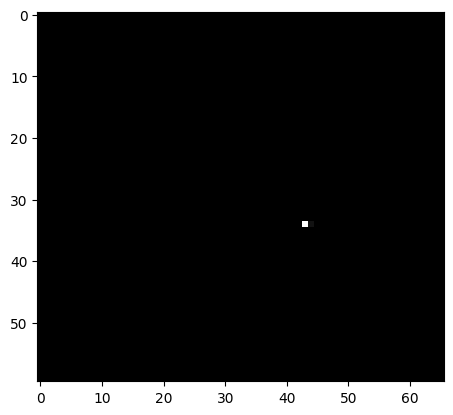

A XZ slice of 'fa' image for 'ksads_1_187_t'


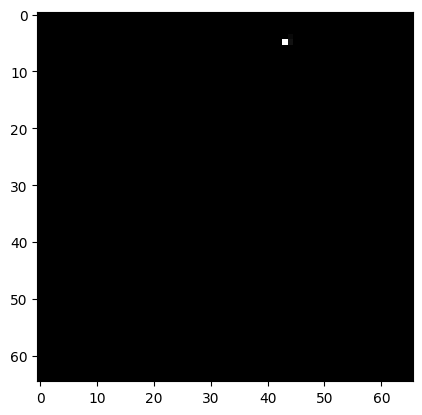

A XY slice of 'fa' image for 'ksads_1_187_t'


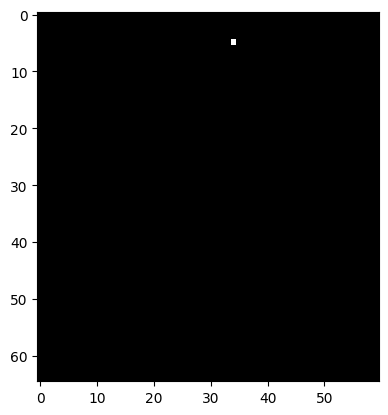

A YZ slice of 'fa' image for 'ksads_1_188_t'


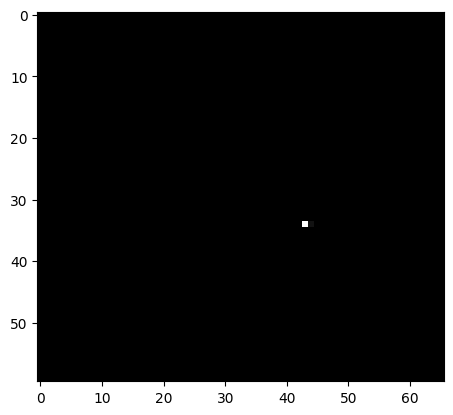

A XZ slice of 'fa' image for 'ksads_1_188_t'


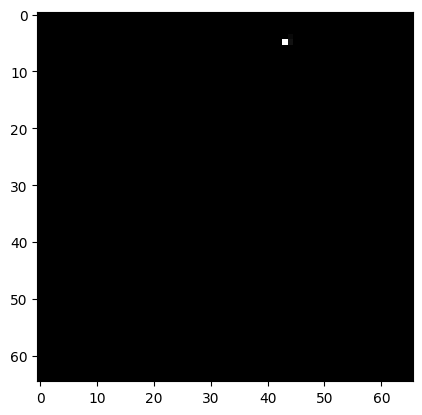

A XY slice of 'fa' image for 'ksads_1_188_t'


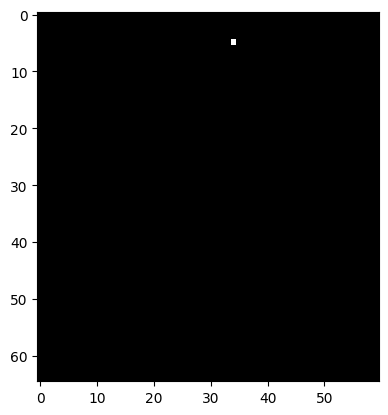

A YZ slice of 'fa' image for 'ksads_22_142_t'


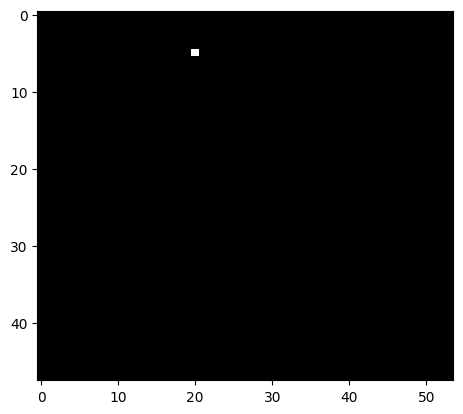

A XZ slice of 'fa' image for 'ksads_22_142_t'


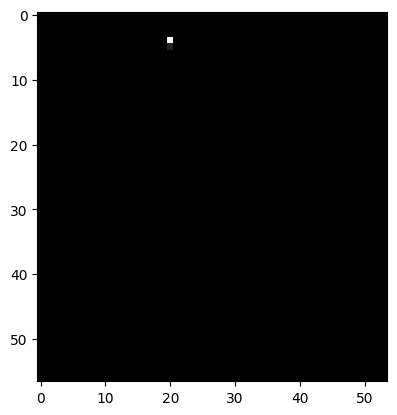

A XY slice of 'fa' image for 'ksads_22_142_t'


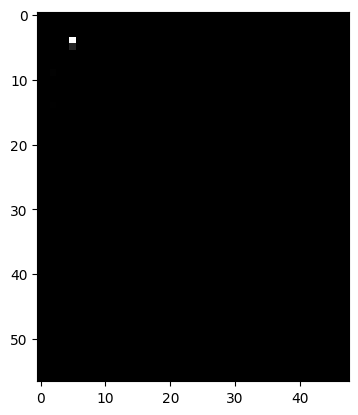

A YZ slice of 'fa' image for 'ksads_22_970_t'


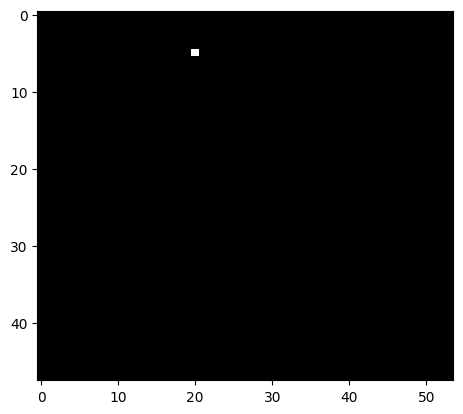

A XZ slice of 'fa' image for 'ksads_22_970_t'


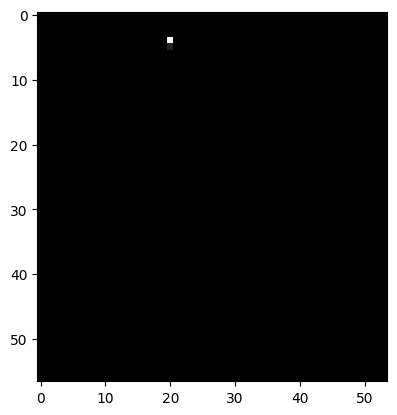

A XY slice of 'fa' image for 'ksads_22_970_t'


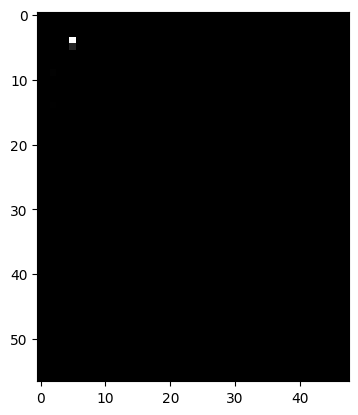

A YZ slice of 'fa' image for 'ksads_2_11_t'


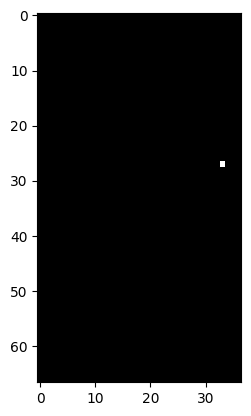

A XZ slice of 'fa' image for 'ksads_2_11_t'


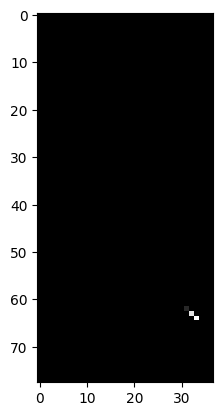

A XY slice of 'fa' image for 'ksads_2_11_t'


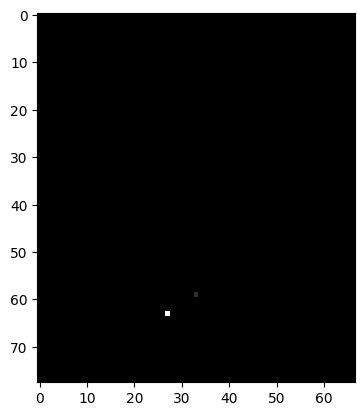

## sub_type = 'md'
## table: table = 't'
output_voxels_by_subtype['md']['t'].shape = (5, 96591)
np.sum(output_voxels_by_subtype['md']['t']) = nan
np.sum(~np.isnan(output_voxels_by_subtype['md']['t'])) = 462665
## table: table = 'logp_max_t'
output_voxels_by_subtype['md']['logp_max_t'].shape = (5, 96591)
np.sum(output_voxels_by_subtype['md']['logp_max_t']) = 7.786175507041818
np.sum(~np.isnan(output_voxels_by_subtype['md']['logp_max_t'])) = 482955
## table: table = 'h0_max_t'
output_voxels_by_subtype['md']['h0_max_t'].shape = (5, 1000)
np.sum(output_voxels_by_subtype['md']['h0_max_t']) = 22876.55827933688
np.sum(~np.isnan(output_voxels_by_subtype['md']['h0_max_t'])) = 5000
output_images_for_subtype['md'].shape = (5, 140, 140, 140)
np.amin(output_images_for_subtype['md']) = 0.0
np.amax(output_images_for_subtype['md']) = 0.7882464730753608

A YZ slice of 'md' image for 'ksads_1_187_t'


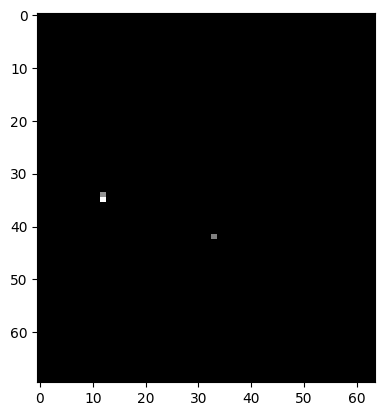

A XZ slice of 'md' image for 'ksads_1_187_t'


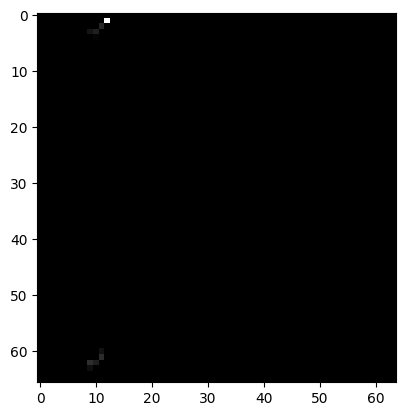

A XY slice of 'md' image for 'ksads_1_187_t'


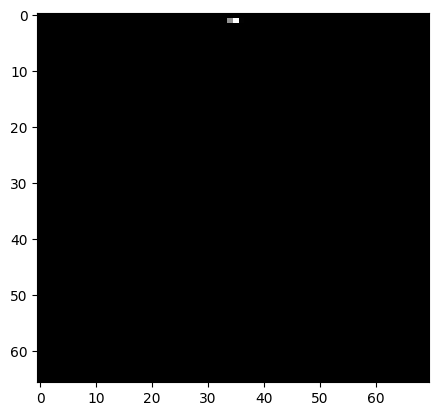

A YZ slice of 'md' image for 'ksads_1_188_t'


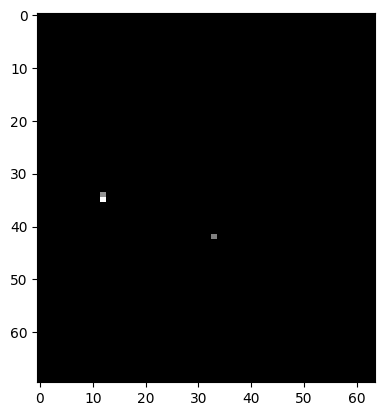

A XZ slice of 'md' image for 'ksads_1_188_t'


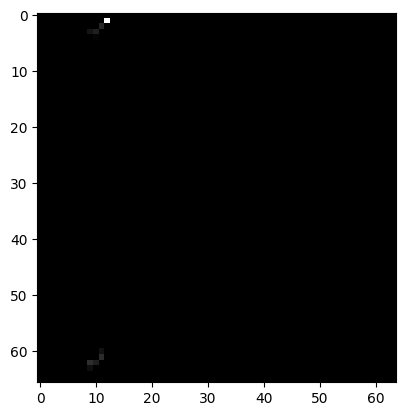

A XY slice of 'md' image for 'ksads_1_188_t'


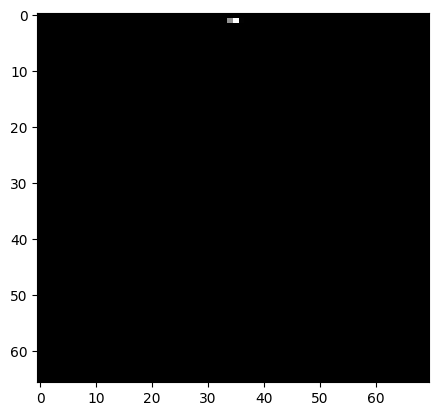

A YZ slice of 'md' image for 'ksads_22_142_t'


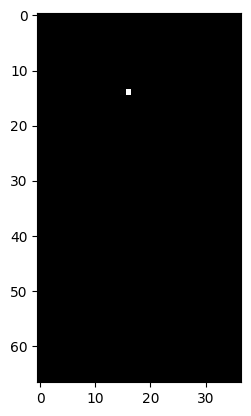

A XZ slice of 'md' image for 'ksads_22_142_t'


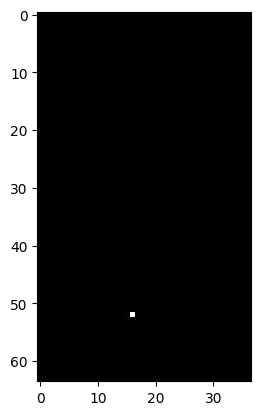

A XY slice of 'md' image for 'ksads_22_142_t'


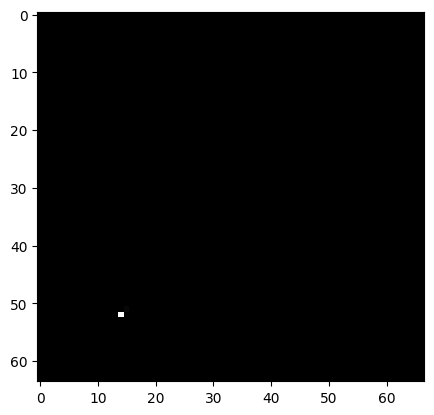

A YZ slice of 'md' image for 'ksads_22_970_t'


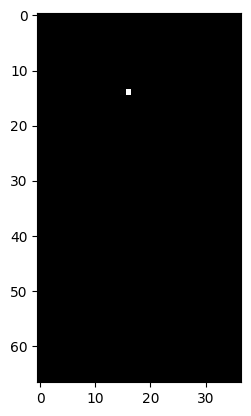

A XZ slice of 'md' image for 'ksads_22_970_t'


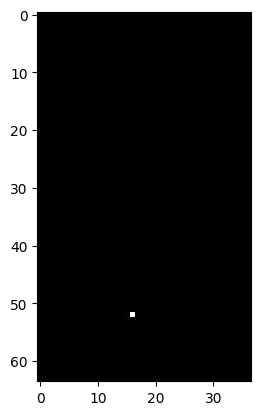

A XY slice of 'md' image for 'ksads_22_970_t'


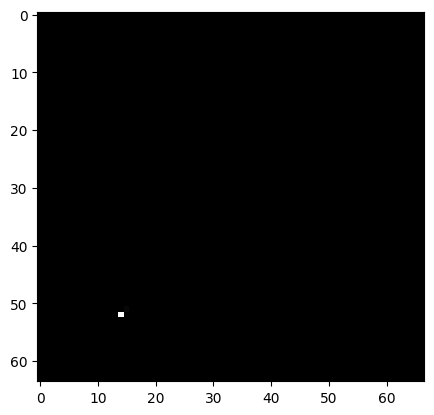

A YZ slice of 'md' image for 'ksads_2_11_t'


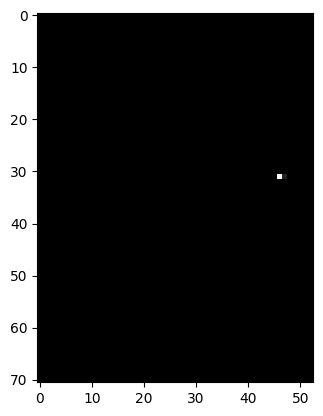

A XZ slice of 'md' image for 'ksads_2_11_t'


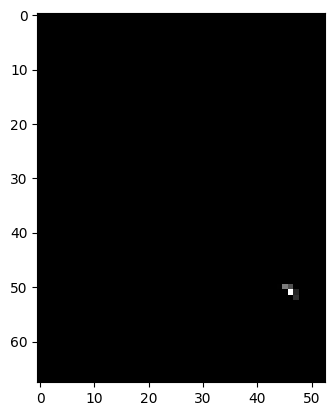

A XY slice of 'md' image for 'ksads_2_11_t'


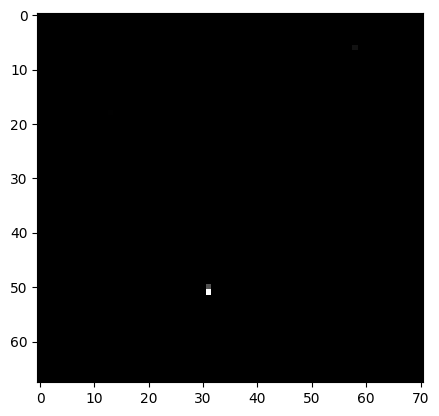

In [15]:
def find_good_slice(margins):
    """
    For each ksads variable, we want to show an interesting slice of the 3d-data.
    For example, we choose a slice in the X dimension (i.e., we choose a YZ plane) by designating its x coordinate and its lower and upper bounds for y and z.
    First step is summing out over the Y and Z dimensions to compute `margins`, which is done before calling find_good_slice().
    (`margins` is 2-dimensional; it is computed from 4-dimensional data with shape=(number_tested_variables, size_x, size_y, size_z))
    We then compute:
        for i in range(list_of_tested_variables):
            min_[i] = The lowest x for which margins[i, x] is non-zero
            max_[i] = One more than the largest x for which margins[i, x] is non-zero
            best_[i] = The (first) value of x that maximizes margins[i, :]
    This routine works identically for slices in the Y or Z dimensions, so long as margins is supplied by summing out the remaining dimensions.
    """
    min_ = np.argmax(margins > 0.0, axis=-1)
    best_ = np.argmax(margins, axis=-1)
    max_ = np.argmax(np.cumsum(margins > 0.0, axis=-1), axis=-1) + 1
    return min_, best_, max_


if func == use_nilearn:
    # We used use_numpy().  Show some values that might help us to sanity check these outputs.
    # nilearn returned only voxels in the white matter, so we construct images that include background
    output_images_by_subtype = {}
    white_matter_indices = (white_matter_mask_input.get_fdata() > 0).reshape(-1)
    print("## use_nilearn output")
    for sub_type in output_voxels_by_subtype.keys():
        print(f"## {sub_type = }")
        for table in output_voxels_by_subtype[sub_type].keys():
            # The three types of table are ['t', 'logp_max_t', 'h0_max_t'].  We're probably most interested in 'logp_max_t'.
            print(f"## table: {table = }")
            # Show the shape of this output
            print(
                f"output_voxels_by_subtype[{sub_type!r}][{table!r}].shape = "
                + f"{output_voxels_by_subtype[sub_type][table].shape}"
            )
            # Show the sum of all values of this output
            print(
                f"np.sum(output_voxels_by_subtype[{sub_type!r}][{table!r}]) = "
                + f"{np.sum(output_voxels_by_subtype[sub_type][table])}"
            )
            # Count how many of the values are not NaNs.
            print(
                f"np.sum(~np.isnan(output_voxels_by_subtype[{sub_type!r}][{table!r}])) = "
                + f"{np.sum(~np.isnan(output_voxels_by_subtype[sub_type][table]))}"
            )
            # Ask to see the whole table; though Python cuts out much of it
            # print(
            #     f"output_voxels_by_subtype[{sub_type!r}][{table!r}] = "
            #     + f"{output_voxels_by_subtype[sub_type][table]}"
            # )
        number_tested_vars = output_voxels_by_subtype[sub_type]["logp_max_t"].shape[0]
        # We will make an output image for each tested variable (i.e., each KSADS variable)
        # Background is zeros
        output_images_for_subtype = np.zeros(
            (number_tested_vars,) + white_matter_mask_input.get_fdata().shape
        )
        # Forground is from nilearn
        output_images_for_subtype.reshape(number_tested_vars, -1)[:, white_matter_indices] = (
            output_voxels_by_subtype[sub_type]["logp_max_t"]
        )
        # Stash the image into a dictionary that we are building
        output_images_by_subtype[sub_type] = output_images_for_subtype
        # Show the shape of the image
        print(
            f"output_images_for_subtype[{sub_type!r}].shape = "
            + f"{output_images_for_subtype.shape}"
        )
        # Show the minimum voxel intensity
        print(
            f"np.amin(output_images_for_subtype[{sub_type!r}]) = "
            + f"{np.amin(output_images_for_subtype)}"
        )
        # Show the maximum voxel intensity
        print(
            f"np.amax(output_images_for_subtype[{sub_type!r}]) = "
            + f"{np.amax(output_images_for_subtype)}"
        )

        # Find interestig slices to plot.
        # For each tested variable (i.e. each KSADS variable), we'll have one X slice, one Y slice, and one Z slice.
        x_margins = output_images_for_subtype.sum(axis=(2, 3))
        minX, bestX, maxX = find_good_slice(x_margins)

        y_margins = output_images_for_subtype.sum(axis=(1, 3))
        minY, bestY, maxY = find_good_slice(y_margins)

        z_margins = output_images_for_subtype.sum(axis=(1, 2))
        minZ, bestZ, maxZ = find_good_slice(z_margins)

        # print()
        # print(f"{minX = }")
        # print(f"{bestX = }")
        # print(f"{maxX = }")
        # print(f"{minY = }")
        # print(f"{bestY = }")
        # print(f"{maxY = }")
        # print(f"{minZ = }")
        # print(f"{bestZ = }")
        # print(f"{maxZ = }")

        print()
        # Set gamma to, e.g., 0.1 or 0.01 to change the contrast of the image.
        # Lower values of gamma brighten the darkest voxels the most
        gamma = 1.0
        for i in range(number_tested_vars):
            # For each tested variable (i.e. each KSADS variable), we'll have one X slice, one Y slice, and one Z slice.
            print(f"A YZ slice of {sub_type!r} image for {interesting_ksads_input[i]!r}")
            slice_2d = output_images_for_subtype[i, bestX[i], minY[i] : maxY[i], minZ[i] : maxZ[i]]
            slice_2d = np.pow(slice_2d, gamma)  # Gamma correction
            plt.imshow(slice_2d, cmap="gray")
            # plt.colorbar()
            plt.show()

            print(f"A XZ slice of {sub_type!r} image for {interesting_ksads_input[i]!r}")
            slice_2d = output_images_for_subtype[i, minX[i] : maxX[i], bestY[i], minZ[i] : maxZ[i]]
            slice_2d = np.pow(slice_2d, gamma)  # Gamma correction
            plt.imshow(slice_2d, cmap="gray")
            # plt.colorbar()
            plt.show()

            print(f"A XY slice of {sub_type!r} image for {interesting_ksads_input[i]!r}")
            slice_2d = output_images_for_subtype[i, minX[i] : maxX[i], minY[i] : maxY[i], bestZ[i]]
            slice_2d = np.pow(slice_2d, gamma)  # Gamma correction
            plt.imshow(slice_2d, cmap="gray")
            # plt.colorbar()
            plt.show()

    # print(output_images_by_subtype)
else:
    print("Skipped use_nilearn output")